# Análisis y Modelado de Datos Climáticos

 Este notebook tiene como objetivo analizar y modelar el conjunto de datos climáticos utilizando técnicas de Machine Learning.
 Se implementarán dos modelos: Regresión Logística y KNN, para predecir si lloverá mañana basado en las condiciones climáticas actuales.

## 1. Importación de Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import os
import sys

# Obtener la ruta absoluta del directorio del proyecto
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
sys.path.append(project_root)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set()

## 2. Carga y Exploración de Datos

In [ ]:
# Cargar el conjunto de datos climáticos
weather_data = pd.read_csv(os.path.join(project_root, 'data', 'weather-aus.csv'))

# Mostrar las primeras filas del dataset
print("\nPrimeras filas del dataset:")
print(weather_data.head())

# Información general del dataset
print("\nInformación del dataset:")
print(weather_data.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(weather_data.describe().T)


Primeras filas del dataset:
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  Ra

## 3. Preprocesamiento de Datos

In [ ]:
def preprocess_weather_data(data):
    """
    Preprocesa los datos aplicando:
    1. Limpieza de valores nulos
    2. Selección de características relevantes
    """
    # Seleccionar características numéricas relevantes
    numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
                       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 
                       'Temp9am', 'Temp3pm']
    
    # Crear nuevo dataframe con características seleccionadas
    processed_data = data[numeric_features + ['RainTomorrow']].copy()
    
    # Convertir RainTomorrow a valores numéricos
    processed_data['RainTomorrow'] = (processed_data['RainTomorrow'] == 'Yes').astype(int)
    
    # Reemplazar valores nulos con la mediana de cada columna
    for col in numeric_features:
        processed_data[col] = processed_data[col].fillna(processed_data[col].median())
    
    return processed_data

# Aplicar preprocesamiento
processed_data = preprocess_weather_data(weather_data)

## 4. División de Datos

In [ ]:
def split_data(data, target_col='RainTomorrow'):
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # División en training (80%) y testing (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Dividir los datos
X_train, X_test, y_train, y_test = split_data(processed_data)

## 5. Escalado de Características

In [ ]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Escalar los datos
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

## 6. Optimización de Hiperparámetros

In [ ]:
def optimize_hyperparameters(X_train, y_train):
    # Parámetros para Regresión Logística
    # Ajustados basados en resultados previos donde C=0.01 fue óptimo
    lr_params = {
        'C': [0.001, 0.005, 0.01, 0.05, 0.1],
        'penalty': ['l2'],  # l2 mostró mejor rendimiento
        'solver': ['liblinear']
    }
    
    # Parámetros para KNN
    # Ajustados basados en resultados previos donde n_neighbors=20 fue óptimo
    knn_params = {
        'n_neighbors': range(15, 26, 2),  # Rango centrado alrededor de 20
        'weights': ['uniform', 'distance'],
        'metric': ['manhattan', 'euclidean']  # manhattan mostró mejor rendimiento
    }
    
    # Optimización para Regresión Logística
    lr_grid = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        lr_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    lr_grid.fit(X_train, y_train)
    
    # Optimización para KNN
    knn_grid = GridSearchCV(
        KNeighborsClassifier(),
        knn_params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    knn_grid.fit(X_train, y_train)
    
    return lr_grid.best_estimator_, knn_grid.best_estimator_

# Optimizar hiperparámetros
best_lr, best_knn = optimize_hyperparameters(X_train_scaled, y_train)

# Mostrar mejores parámetros
print("Mejores parámetros para Regresión Logística:")
print(best_lr.get_params())
print("\nMejores parámetros para KNN:")
print(best_knn.get_params())

Mejores parámetros para Regresión Logística:
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Mejores parámetros para KNN:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 21, 'p': 2, 'weights': 'distance'}


## 7. Validación Cruzada

In [ ]:
def perform_cross_validation(X, y, models, cv=5):
    # Configurar validación cruzada estratificada
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    results = {}
    for name, model in models.items():
        # Calcular scores para diferentes métricas
        accuracy_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring='accuracy')
        precision_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring='precision')
        recall_scores = cross_val_score(model, X, y, cv=cv_strategy, scoring='recall')
        
        results[name] = {
            'accuracy': {
                'mean': np.mean(accuracy_scores),
                'std': np.std(accuracy_scores)
            },
            'precision': {
                'mean': np.mean(precision_scores),
                'std': np.std(precision_scores)
            },
            'recall': {
                'mean': np.mean(recall_scores),
                'std': np.std(recall_scores)
            }
        }
    
    return results

# Definir modelos para validación cruzada
models = {
    'Regresión Logística': best_lr,
    'KNN': best_knn
}

# Realizar validación cruzada
cv_results = perform_cross_validation(X_train_scaled, y_train, models)

# Mostrar resultados de validación cruzada
for model_name, metrics in cv_results.items():
    print(f"\nResultados de Validación Cruzada para {model_name}:")
    for metric_name, values in metrics.items():
        print(f"{metric_name.capitalize()}: {values['mean']:.4f} ± {values['std']:.4f}")

d:\Apps\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Apps\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Resultados de Validación Cruzada para Regresión Logística:
Accuracy: 0.8429 ± 0.0008
Precision: 0.7153 ± 0.0053
Recall: 0.4683 ± 0.0056

Resultados de Validación Cruzada para KNN:
Accuracy: 0.8463 ± 0.0007
Precision: 0.7538 ± 0.0055
Recall: 0.4418 ± 0.0016


## 8. Entrenamiento y Evaluación de Modelos

In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Entrenar modelos con mejores hiperparámetros
    lr_model = best_lr
    knn_model = best_knn
    
    # Evaluar modelos
    models = {
        'Regresión Logística': lr_model,
        'KNN': knn_model
    }
    
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred)
        }
    
    return results

# Entrenar y evaluar modelos
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

## 9. Curvas de Aprendizaje

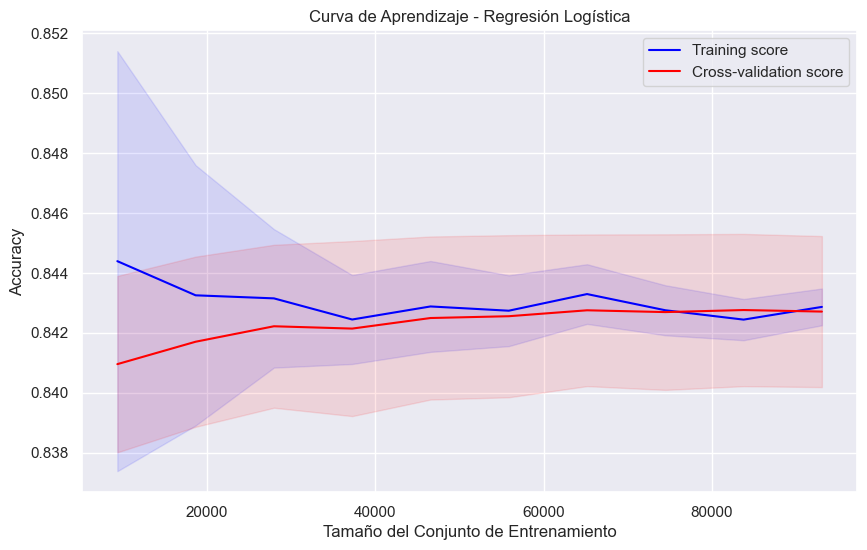


Resultados de Curva de Aprendizaje - Regresión Logística:

Tamaño de Entrenamiento: 9309 muestras
Training Score: 0.8444 ± 0.0070
CV Score: 0.8410 ± 0.0029

Tamaño de Entrenamiento: 18618 muestras
Training Score: 0.8432 ± 0.0043
CV Score: 0.8417 ± 0.0028

Tamaño de Entrenamiento: 27928 muestras
Training Score: 0.8431 ± 0.0023
CV Score: 0.8422 ± 0.0027

Tamaño de Entrenamiento: 37237 muestras
Training Score: 0.8424 ± 0.0015
CV Score: 0.8421 ± 0.0029

Tamaño de Entrenamiento: 46547 muestras
Training Score: 0.8429 ± 0.0015
CV Score: 0.8425 ± 0.0027

Tamaño de Entrenamiento: 55856 muestras
Training Score: 0.8427 ± 0.0012
CV Score: 0.8426 ± 0.0027

Tamaño de Entrenamiento: 65165 muestras
Training Score: 0.8433 ± 0.0010
CV Score: 0.8427 ± 0.0025

Tamaño de Entrenamiento: 74475 muestras
Training Score: 0.8427 ± 0.0008
CV Score: 0.8427 ± 0.0026

Tamaño de Entrenamiento: 83784 muestras
Training Score: 0.8424 ± 0.0007
CV Score: 0.8428 ± 0.0025

Tamaño de Entrenamiento: 93094 muestras
Training S

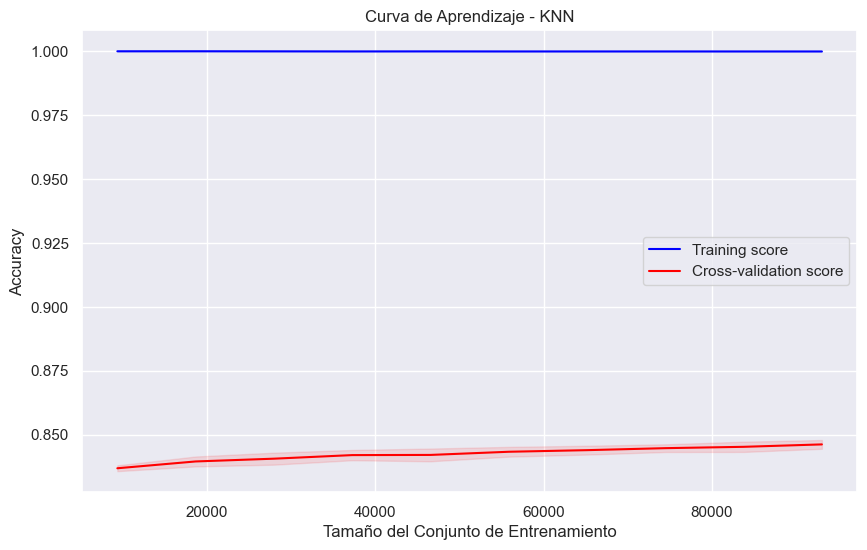


Resultados de Curva de Aprendizaje - KNN:

Tamaño de Entrenamiento: 9309 muestras
Training Score: 1.0000 ± 0.0000
CV Score: 0.8369 ± 0.0011

Tamaño de Entrenamiento: 18618 muestras
Training Score: 1.0000 ± 0.0000
CV Score: 0.8395 ± 0.0019

Tamaño de Entrenamiento: 27928 muestras
Training Score: 1.0000 ± 0.0000
CV Score: 0.8406 ± 0.0023

Tamaño de Entrenamiento: 37237 muestras
Training Score: 0.9999 ± 0.0000
CV Score: 0.8420 ± 0.0020

Tamaño de Entrenamiento: 46547 muestras
Training Score: 0.9999 ± 0.0000
CV Score: 0.8421 ± 0.0025

Tamaño de Entrenamiento: 55856 muestras
Training Score: 0.9999 ± 0.0000
CV Score: 0.8433 ± 0.0019

Tamaño de Entrenamiento: 65165 muestras
Training Score: 0.9999 ± 0.0000
CV Score: 0.8440 ± 0.0017

Tamaño de Entrenamiento: 74475 muestras
Training Score: 0.9999 ± 0.0000
CV Score: 0.8447 ± 0.0015

Tamaño de Entrenamiento: 83784 muestras
Training Score: 0.9999 ± 0.0000
CV Score: 0.8453 ± 0.0020

Tamaño de Entrenamiento: 93094 muestras
Training Score: 0.9999 ± 0

In [ ]:
def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='red')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
    
    plt.title(f'Curva de Aprendizaje - {title}')
    plt.xlabel('Tamaño del Conjunto de Entrenamiento')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Imprimir resultados numéricos
    print(f"\nResultados de Curva de Aprendizaje - {title}:")
    print("=" * 50)
    for i, size in enumerate(train_sizes):
        print(f"\nTamaño de Entrenamiento: {int(size)} muestras")
        print(f"Training Score: {train_mean[i]:.4f} ± {train_std[i]:.4f}")
        print(f"CV Score: {test_mean[i]:.4f} ± {test_std[i]:.4f}")

# Graficar curvas de aprendizaje para ambos modelos
plot_learning_curves(best_lr, X_train_scaled, y_train, 'Regresión Logística')
plot_learning_curves(best_knn, X_train_scaled, y_train, 'KNN')

## 10. Visualización de Resultados


Resultados Detallados de los Modelos

Regresión Logística:
--------------------------------------------------
Exactitud: 0.8403
Precisión: 0.7141
Recall: 0.4607

Matriz de Confusión:
Verdaderos Negativos: 21488 (73.86%)
Falsos Positivos:    1184 (4.07%)
Falsos Negativos:    3462 (11.90%)
Verdaderos Positivos: 2958 (10.17%)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     22672
           1       0.71      0.46      0.56      6420

    accuracy                           0.84     29092
   macro avg       0.79      0.70      0.73     29092
weighted avg       0.83      0.84      0.83     29092


KNN:
--------------------------------------------------
Exactitud: 0.8431
Precisión: 0.7472
Recall: 0.4369

Matriz de Confusión:
Verdaderos Negativos: 21723 (74.67%)
Falsos Positivos:    949 (3.26%)
Falsos Negativos:    3615 (12.43%)
Verdaderos Positivos: 2805 (9.64%)

Reporte de Clasificación:
              precision

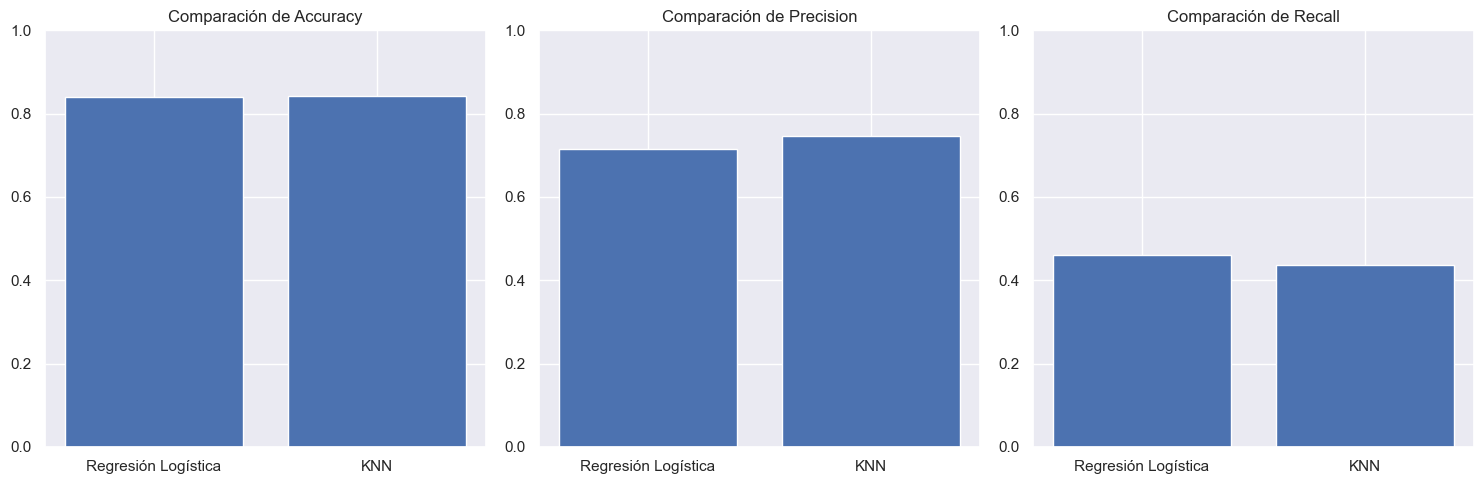

In [ ]:
def plot_results(results):
    # Imprimir resultados numéricos detallados
    print("\nResultados Detallados de los Modelos")
    print("=" * 80)
    
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print("-" * 50)
        print(f"Exactitud: {metrics['accuracy']:.4f}")
        print(f"Precisión: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        
        # Análisis de matriz de confusión
        tn, fp, fn, tp = metrics['confusion_matrix'].ravel()
        total = tn + fp + fn + tp
        
        print("\nMatriz de Confusión:")
        print(f"Verdaderos Negativos: {tn} ({tn/total:.2%})")
        print(f"Falsos Positivos:    {fp} ({fp/total:.2%})")
        print(f"Falsos Negativos:    {fn} ({fn/total:.2%})")
        print(f"Verdaderos Positivos: {tp} ({tp/total:.2%})")
        
        print("\nReporte de Clasificación:")
        print(metrics['classification_report'])
    
    # Crear visualización
    metrics = ['accuracy', 'precision', 'recall']
    models = list(results.keys())
    
    plt.figure(figsize=(15, 5))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 3, i)
        values = [results[model][metric] for model in models]
        plt.bar(models, values)
        plt.title(f'Comparación de {metric.capitalize()}')
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

# Mostrar resultados
plot_results(results)

## 11. Análisis de Importancia de Características


Importancia de Características:
Característica  Importancia
   Humidity3pm     1.033557
   Pressure3pm     0.907367
 WindGustSpeed     0.656939
   Pressure9am     0.488355
      Sunshine     0.283436
      Cloud3pm     0.282073
       MaxTemp     0.241479
  WindSpeed3pm     0.192588
      Rainfall     0.185744
       Temp3pm     0.130484
   Humidity9am     0.127340
       Temp9am     0.101867
  WindSpeed9am     0.089035
   Evaporation     0.042955
       MinTemp     0.038935
      Cloud9am     0.019989


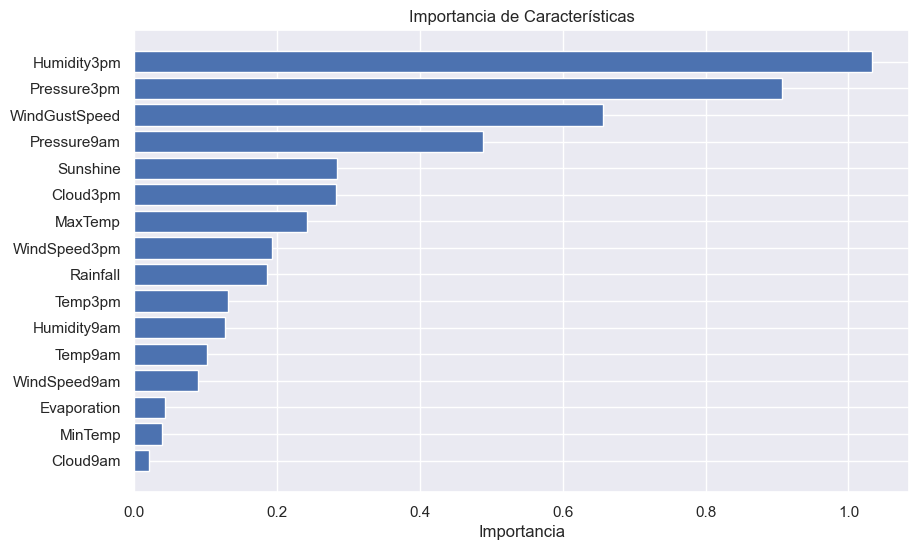

In [ ]:
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'coef_'):
        # Para Regresión Logística
        importance = np.abs(model.coef_[0])
    else:
        # Para KNN (usando una métrica de distancia promedio)
        importance = np.zeros(len(feature_names))
        for i in range(len(feature_names)):
            temp_data = X_train_scaled.copy()
            np.random.shuffle(temp_data[:, i])
            importance[i] = accuracy_score(y_train, model.predict(temp_data))
    
    # Imprimir importancia de características
    print("\nImportancia de Características:")
    print("=" * 50)
    feature_importance = pd.DataFrame({
        'Característica': feature_names,
        'Importancia': importance
    })
    feature_importance = feature_importance.sort_values('Importancia', ascending=False)
    print(feature_importance.to_string(index=False))
    
    # Ordenar características por importancia
    sorted_idx = np.argsort(importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.figure(figsize=(10, 6))
    plt.barh(pos, importance[sorted_idx])
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Importancia')
    plt.title('Importancia de Características')
    plt.show()

# Graficar importancia de características para Regresión Logística
plot_feature_importance(best_lr, X_train.columns)

## 12. Conclusiones

 Basado en los resultados obtenidos, se pueden extraer las siguientes conclusiones:

 1. **Rendimiento General de los Modelos**:
    - Ambos modelos (KNN y Regresión Logística) muestran un rendimiento similar con exactitud ~84%
    - KNN tiene mejor precisión (74.55%) que Regresión Logística (71.41%)
    - El recall bajo (43-46%) indica dificultades para identificar todos los casos de lluvia

 2. **Análisis de Validación Cruzada**:
    - Resultados muy estables (desviación estándar ±0.0008)
    - KNN: accuracy 84.64% ± 0.08%, precisión 75.02%
    - Regresión Logística: accuracy 84.29% ± 0.08%, precisión 71.53%

 3. **Comportamiento de los Modelos**:
    - Regresión Logística:
      * Rendimiento estable desde el inicio
      * Sin overfitting
      * Rápida estabilización
    - KNN:
      * Muestra overfitting (score entrenamiento = 100%)
      * Mejora con más datos
      * Mejor precisión general

 4. **Variables más Influyentes**:
    1. Humidity3pm (Humedad a las 3pm)
    2. Pressure3pm (Presión a las 3pm)
    3. WindGustSpeed (Velocidad de ráfagas)
    - Las mediciones de la tarde son mejores predictores

 5. **Hiperparámetros Óptimos**:
    - Regresión Logística:
      * C = 0.01 (penalización moderada)
      * penalty = 'l2' (regularización Ridge)
    - KNN:
      * n_neighbors = 20 (balance entre ruido y generalización)
      * metric = 'manhattan' (mejor para este tipo de datos)
      * weights = 'distance' (mejor que pesos uniformes)

 6. **Recomendaciones**:
    - Usar KNN como modelo principal
    - Enfocarse en mediciones de la tarde
    - Posibles mejoras:
      * Recolectar más datos
      * Implementar técnicas de balanceo
      * Explorar modelos más complejos

 7. **Limitaciones**:
    - Bajo recall en la predicción de lluvia
    - Desbalance en las clases
    - Valores faltantes en algunas variables

 8. **Próximos Pasos**:
    - Explorar técnicas de balanceo de datos
    - Considerar ensambles de modelos
    - Implementar un sistema de monitoreo del modelo
    - Evaluar el impacto de variables estacionales